In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import requests
from IPython.display import JSON

In [13]:
url = "https://ionbeam-dev.ecmwf.int/api/v1/"
url = "https://ionbeam-test.ecmwf.int/api/v1/"
# url = "http://127.0.0.1:5002/api/v1/"

In [14]:
# Load in the ECMWF token 
with open(Path("~/.ecmwfapirc").expanduser(), "r") as f:
    api_creds = json.load(f)

print("Checking API credentials")
r = requests.get(f"https://api.ecmwf.int/v1/who-am-i?token={api_creds['key']}")
if r.status_code == 403: print("Your credentials are either wrong or have expired and need to be renewed at https://api.ecmwf.int/v1/key/")
r.raise_for_status()

# Make a session object the requests library can reuse connections
session = requests.Session()
session.headers["Authorization"] = f"Bearer {api_creds['key']}"

Checking API credentials


In [16]:
session.get(url + "stations").text

'<!doctype html>\n<html lang=en>\n  <head>\n    <title>requests.exceptions.ConnectionError: HTTPConnectionPool(host=&#39;iotdev-002&#39;, port=18201): Max retries exceeded with url: /api/v1/stations (Caused by NameResolutionError(&#34;&lt;urllib3.connection.HTTPConnection object at 0x7f4a38629d60&gt;: Failed to resolve &#39;iotdev-002&#39; ([Errno -2] Name or service not known)&#34;))\n // Werkzeug Debugger</title>\n    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css">\n    <link rel="shortcut icon"\n        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">\n    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>\n    <script>\n      var CONSOLE_MODE = false,\n          EVALEX = false,\n          EVALEX_TRUSTED = false,\n          SECRET = "zVUmEwt8HPQ7xvyOIvKZ";\n    </script>\n  </head>\n  <body style="background-color: #fff">\n    <div class="debugger">\n<h1>ConnectionError</h1>\n<div class="detail">\n  <p class="er

In [15]:
stations = session.get(url + "stations").json()
print(f"{len(stations) = }")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [5]:
stations[0]

{'external_id': '62ab72c11d8e11061d32002a',
 'platform': 'meteotracker',
 'location_point': 'POINT (8.65711845 44.3934191)',
 'location_bbox': 'POLYGON ((8.675219 44.386031, 8.675219 44.4008072, 8.6390179 44.4008072, 8.6390179 44.386031, 8.675219 44.386031))',
 'location_hull': 'POLYGON ((8.6391694 44.386031, 8.6391037 44.3860898, 8.6390179 44.3863223, 8.6391489 44.3864548, 8.6393916 44.3866083, 8.6636556 44.3988833, 8.6672147 44.4002499, 8.6676504 44.4003547, 8.6690215 44.4005383, 8.6708526 44.4007344, 8.6736574 44.4008072, 8.6742229 44.4007635, 8.6746885 44.4006371, 8.6750503 44.4005098, 8.675219 44.400353, 8.6750815 44.4002186, 8.6655395 44.3914033, 8.665203 44.3911424, 8.664728 44.3910255, 8.6391694 44.386031))',
 'start_time': '2022-06-16T18:13:15Z',
 'stop_time': '2022-06-16T18:21:09Z',
 'authors': [{'name': 'genova_living_lab_1', 'description': None, 'url': None},
  {'name': 'meteotracker', 'description': None, 'url': None}],
 'sensors': [{'name': 'meteotracker Sensor',
   'desc

In [6]:
from collections import defaultdict, Counter
def map_to_simple_author(authors):
    lls = ["Bologna", "Genova", "Jerusalem", "LLWA", "Barcelona", "Dublin", "CIMA", "Amsterdam"]
    for ll in lls:
        for a in authors:
            if "gert-jan" in a["name"].lower():
                return "Amsterdam", a["name"]
            if ll.lower() in a["name"].lower():
                return ll, a["name"]
    return "/".join(a["name"] for a in authors), None


grouped = defaultdict(Counter)
for s in stations:
    nice_name, original_name = map_to_simple_author(s["authors"])
    grouped[nice_name][original_name] += 1

for ll, breakdown in grouped.items():
    print(f"Living Lab: {ll} - Total datasets: {sum(breakdown.values())}")
    for name, count in breakdown.items():
        print(f"    {name} : {count}")
    print()

Living Lab: Genova - Total datasets: 2062
    genova_living_lab_1 : 1090
    genova_living_lab_10 : 8
    genova_living_lab_2 : 52
    genova_living_lab_6 : 46
    genova_living_lab_4 : 12
    genova_living_lab_5 : 6
    genova_living_lab_3 : 27
    genova_living_lab_7 : 78
    genova_living_lab_8 : 228
    genova_living_lab_9 : 21
    genova_living_lab_11 : 109
    genova_living_lab_12 : 39
    genova_living_lab_19 : 10
    genova_living_lab_14 : 61
    genova_living_lab_13 : 56
    genova_living_lab_17 : 28
    genova_living_lab_15 : 26
    genova_living_lab_18 : 24
    genova_living_lab_21 : 53
    genova_living_lab_16 : 9
    genova_living_lab_22 : 17
    genova_living_lab_23 : 2
    genova_living_lab_24 : 53
    genova_living_lab_27 : 7

Living Lab: Bologna - Total datasets: 57
    bologna_living_lab_13 : 4
    bologna_living_lab_6 : 2
    bologna_living_lab_4 : 2
    bologna_living_lab_3 : 6
    bologna_living_lab_1 : 2
    bologna_living_lab_17 : 2
    bologna_living_lab_16 : 2


In [7]:
Counter(s["platform"] for s in stations)

Counter({'meteotracker': 3853})

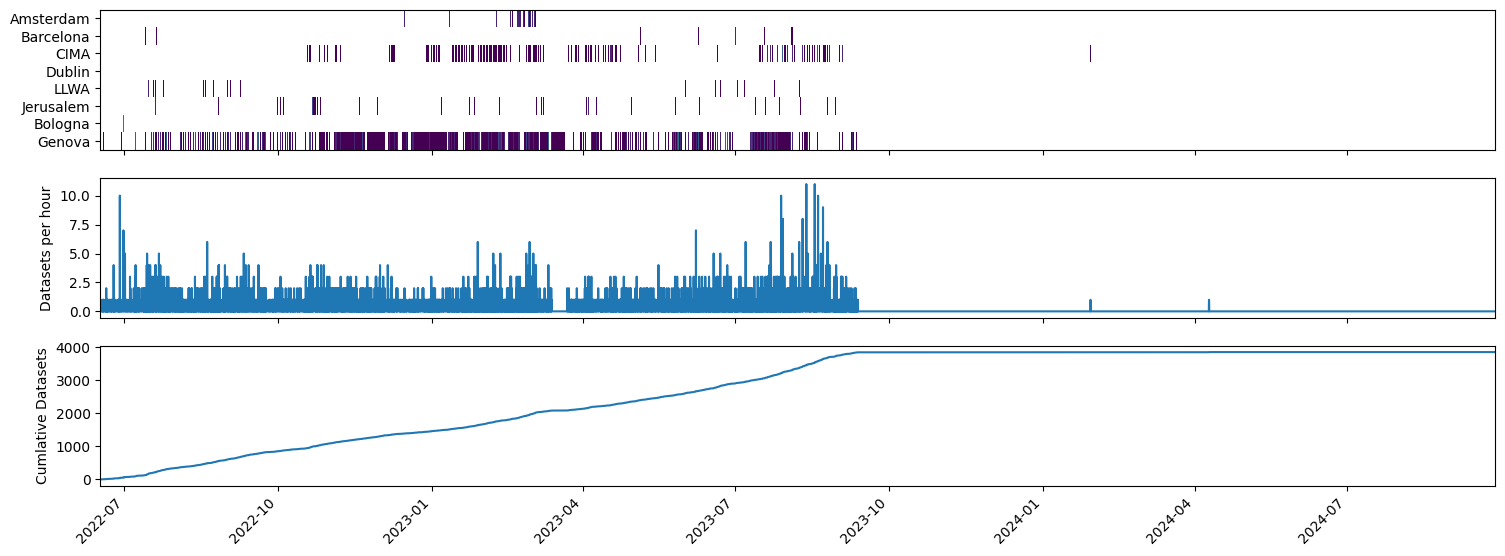

In [12]:
from datetime import datetime as dt
from datetime import timedelta, timezone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

start = min(dt.fromisoformat(station["start_time"]) for station in stations)
end = max(dt.fromisoformat(station["stop_time"]) for station in stations)

# start = min(dt.fromisoformat(station["time_span"][0]) for station in stations)
# end = max(dt.fromisoformat(station["time_span"][1]) for station in stations)

end = dt.now(tz = timezone.utc)
# end = dt(2023, 4, 1, tzinfo = timezone.utc)

times = pd.date_range(start, end + timedelta(hours = 1), freq="1h").to_pydatetime()
station_names = list(grouped.keys())
heatmap = np.zeros(shape = (len(station_names), len(times)))
timeline = np.zeros(shape = len(times))

for station in stations:
    nice_name, _ = map_to_simple_author(station["authors"])
    station_idx = station_names.index(nice_name)
    assert station_idx >= 0
    time_range = pd.date_range(dt.fromisoformat(station["start_time"]), dt.fromisoformat(station["stop_time"]), freq="1h").to_pydatetime()
    # time_range = pd.date_range(dt.fromisoformat(station["time_span"][0]), dt.fromisoformat(station["time_span"][1]), freq="1h").to_pydatetime()
    time_idxs = times.searchsorted(time_range)
    
    # filter out an times that are outside the range we want
    time_idxs = time_idxs[(0 < time_idxs) & (time_idxs < len(times))]
    heatmap[station_idx, time_idxs] += 1
    
    if len(time_idxs): timeline[time_idxs[0]] += 1

heatmap[np.where(heatmap == 0)] = np.NaN

f, axes = plt.subplots(nrows = 3, sharex = True, figsize = (18,7))

ax = axes[0]
ax.pcolormesh(times, station_names, heatmap)
f.autofmt_xdate(rotation=45)

ax = axes[1]
ax.plot(times, timeline)
ax.set(ylabel = "Datasets per hour")

ax = axes[2]
ax.plot(times, timeline.cumsum())
ax.set(ylabel = "Cumlative Datasets");